# Determing Extent of Water Bodies

* **Products used:** 
[ls8_sr](https://explorer.digitalearth.africa/products/ls8_sr),
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2)

## Background
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook primarily focuses on the first sub-indicator - spatial extents.

The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) product shows water observed for Landsat-8 image for selected areas of Africa and it will be used to determine the spatial extent of water.


## Description
The notebook demonstrates how to:

1. Load WOFL data for a given location and time period
2. Set up a Dask cluster
3. Generate a time series
4. Generate a map for two time periods
5. Create animation for the product
6. Compare the two time periods

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import xarray as xr
from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from odc.ui import image_aspect

from deafrica_tools.datahandling import load_ard, wofs_fuser
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb, xr_animation
from deafrica_tools.dask import create_local_dask_cluster

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


While the summary plot is useful at a glance it can be interesting to see the full spatial picture at times .
The code below defines two useful functions: `closest_date` will find the date in a list of dates closest to any given date; 
`date_index` will return the position of a particular date in a list of dates. 
These functions are useful for selecting images to compare. 

In [2]:
def closest_date(list_of_dates, desired_date):
    return min(list_of_dates,
               key=lambda x: abs(x - np.datetime64(desired_date)))

### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app='water_extent')

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [4]:
create_local_dask_cluster()

/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46585 instead
  http_address["port"], self.http_server.port


<Client: 'tcp://127.0.0.1:33659' processes=1 threads=2, memory=13.11 GB>

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:

* `lat`: The central latitude to analyse (e.g. 10.338).
* `lon` : The central longitude to analyse (e.g. -1.055).
* `lat_buffer` : The number of degrees to load around the central latitude.
* `lon_buffer` : The number of degrees to load around the central longitude.

* `Start_year and end_year`: The date range to analyse (e.g. `('2015', '2019')`.

* `Threshold_value`: This value sets the minimum amount of good data a scene must have before it will be loaded into memory e.g. `0.75` means only images with 75% good data will be retained.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of the Lake Sulunga. Tanzania. 


In [5]:
# Define the area of interest
lat = -6.0873
lon = 35.1817

lat_buffer = 0.2
lon_buffer = 0.2

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Define the start year and end year
start_year = '2013'
end_year = '2019'

# Define the threshold
threshold_value = 0.75

## View the Area of Interest on an interactive map
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [6]:
display_map(lon_range, lat_range)

## Load and view Landsat data

The code below will create a query dictionary for our region of interest, find the correct `crs` using the `mostcommon_crs function` for the area of interest, and then load the WOFs product with `dc.load` function.
For more information on loading data, see the [Loading data notebook](../Beginners_guide/03_Loading_data.ipynb).

In [7]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-30, 30),
    'output_crs':'EPSG:6933',
    'time': (start_year, end_year),
    'dask_chunks':{'time':1,'x':1000,'y':1000}
}

#load landsat 8 data
ds_landsat = load_ard(dc=dc,
                     products=['ls8_sr'],
                     measurements=['red', 'green', 'blue'],
                     min_gooddata=0.75,
                     group_by='solar_day',
                     **query)

# Load WOfS
ds = dc.load(product="ga_ls8c_wofs_2",
             fuse_func=wofs_fuser,
             group_by='solar_day',
             **query
            )

print(ds_landsat)

/home/jovyan/Tools/deafrica_tools/datahandling.py:269: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  "Setting 'min_gooddata' percentage to > 0.0 "


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step
Filtering to 65 out of 296 time steps with at least 75.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 65 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 65, x: 1287, y: 1693)
Coordinates:
  * time         (time) datetime64[ns] 2013-04-28T07:52:19.328647 ... 2019-12...
  * y            (y) float64 -7.498e+05 -7.498e+05 ... -8.005e+05 -8.005e+05
  * x            (x) float64 3.375e+06 3.375e+06 ... 3.414e+06 3.414e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  sp

## Calculate the area per pixel
The number of pixels can be used for the area of the waterbody if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [8]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

## Calculating the extent of water
The following cell calculate the following 
1. Select WOfS images at the same time-step as the Landsat data
2. Remove any possible duplicate time-stamps
3. Calculate the area pixels classified as water

In [9]:
# select WOfS images at same timesteps as the Landsat data
ds_valid = ds.sel(time=ds_landsat.time, method='nearest')

#remove any duplicate time-stamps
index = np.unique(ds_valid.time, return_index=True)
ds_valid = ds_valid.isel(time=index[1])

# Only show water pixels
ds_valid_water = ds_valid.water == 128

# Calculate area of water pixels
ds_valid_water_area = ds_valid_water.sum(dim=['x', 'y']) * area_per_pixel

### Plot Monthly Time Series from the `Start year` to `End year`

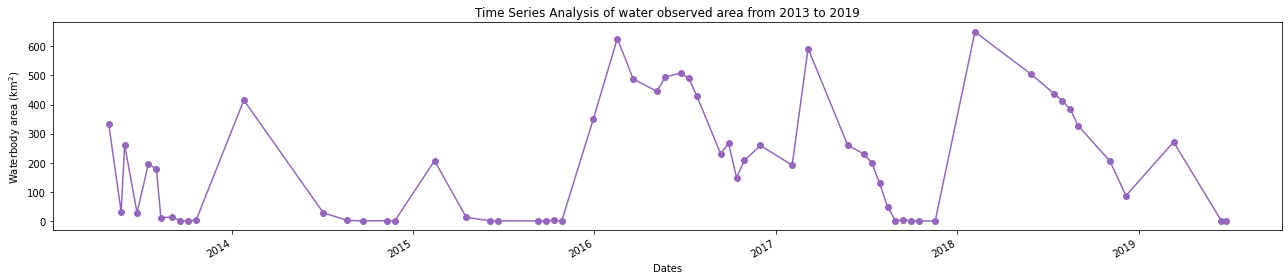

In [10]:
plt.figure(figsize=(18, 4))
ds_valid_water_area.plot(marker='o', color='#9467bd')
plt.title(f'Time Series Analysis of water observed area from {start_year} to {end_year}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

## Determine minimum and maximum water extent
The next cell extract the Minimum and Maximum extent of water from the dataset using the `min` and `max` functions, we then add the dates to an `xarray.DataArray`.

In [11]:
min_water_area_date, max_water_area_date =  min(ds_valid_water_area), max(ds_valid_water_area)
time_xr = xr.DataArray([min_water_area_date.time.values, max_water_area_date.time.values], dims=["time"])

## Plotting
Plot water classified pixel for the two dates where we have the minimum and maximum surface water extent.

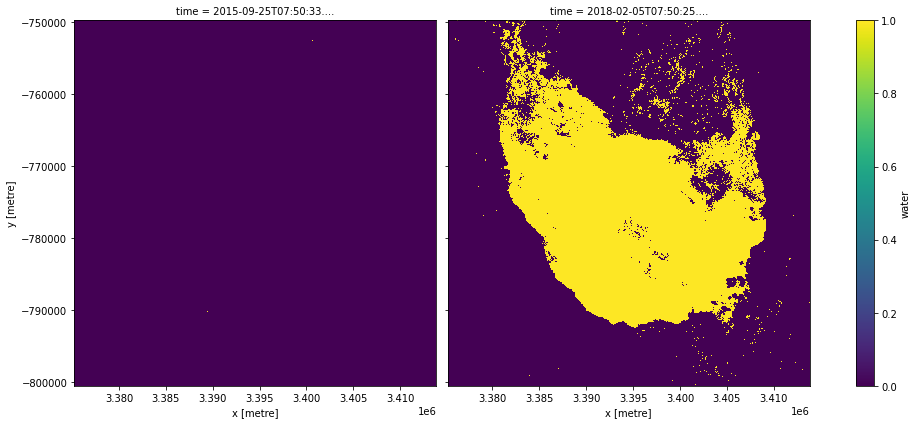

In [12]:
ds_valid_water.sel(time=time_xr).plot.imshow("x","y",col="time", col_wrap=2, robust=True, figsize=(14, 6), cmap='viridis')

Plot the Equivalent landsat  (water classified pixel) for the two dates where we have the minimum and maximum surface water extent.

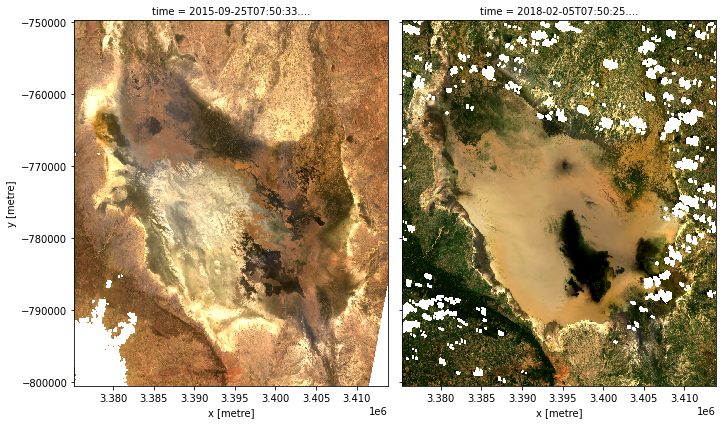

In [13]:
#Determine if data return for landsat  
if ds_landsat.time.size:
    min_water_area_date_landsat = closest_date(ds_landsat.time.values, min_water_area_date.time.values.astype(str))
    max_water_area_date_landsat = closest_date(ds_landsat.time.values, max_water_area_date.time.values.astype(str))

    time_xr_landsat = xr.DataArray([min_water_area_date_landsat, max_water_area_date_landsat], dims=["time"])
    ds_landsat_valid = ds_landsat.sel(time=time_xr_landsat)
    rgb(ds_landsat_valid, col='time') 

## Animating time series
In the next cell, we plot the dataset we loaded above as an animation GIF, using the [`xr_animation`](../Frequently_used_code/Animated_timeseries.ipynb) function.
The `output_path` will be saved in the directory where the script is found and you can change the names to prevent files overwrite.

Exporting animation to water_extent.gif


  0%|          | 0/65 (0.0 seconds remaining at ? frames/s)

distributed.nanny - WARNING - Restarting worker


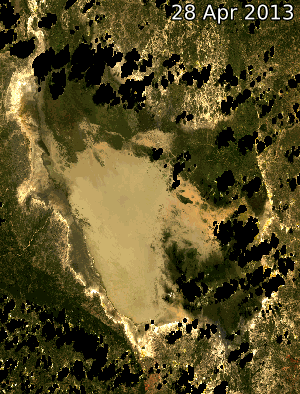

In [14]:
xr_animation(ds=ds_landsat, 
             output_path='water_extent.gif',
             bands = ['red', 'green', 'blue'],
             interval=200, 
             width_pixels=300,
             show_colorbar=False
            )

# Plot animated gif
plt.close()
Image(filename='water_extent.gif')

## Compare Two Time Periods
The following cells determine the maximum extent of water for two different years. 
* `baseline_year` : The baseline year for the analysis
* `analysis_year` : The year to compare to the baseline year

* The maximum water extent for the two years are determine from the datatset `ds_valid_water_area`

In [15]:
baseline_year = 2016
analysis_year = 2019

baseline_ds, analysis_ds = max(ds_valid_water_area[ds_valid_water_area['time.year'] == baseline_year]) , max(ds_valid_water_area[ds_valid_water_area['time.year'] == analysis_year])

A new dataArray is created to store the new date from the `maximum water extent` for the two years

In [16]:
time_xr = xr.DataArray([baseline_ds.time.values, analysis_ds.time.values], dims=["time"])

## Plotting
Plot water extent of the WOFS product for the two years.

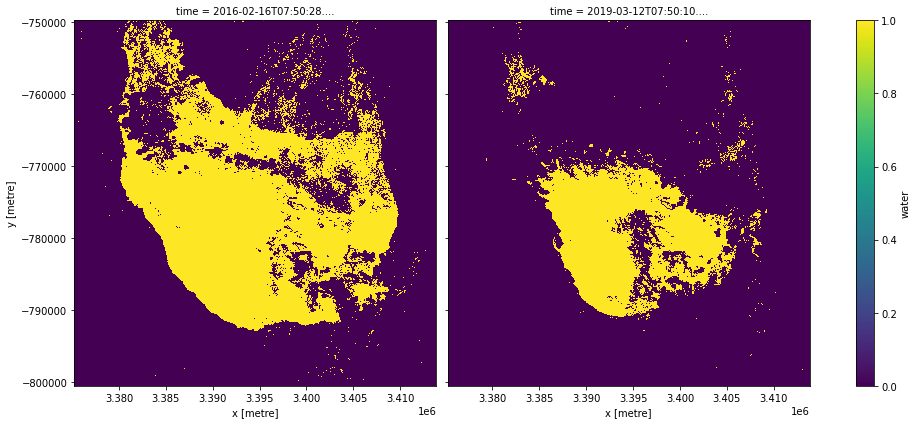

In [17]:
ds_valid_water.sel(time=time_xr).plot.imshow("x","y",col="time", col_wrap=2, robust=True, figsize=(14, 6), cmap='viridis')

Plot the equivalent Landsat for the two dates.

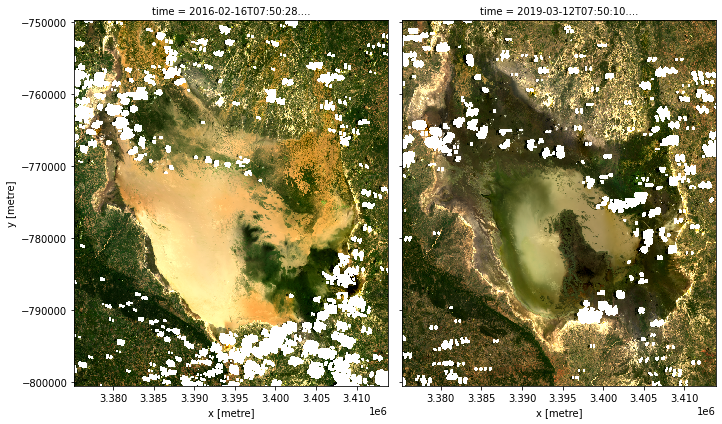

In [18]:
if ds_landsat.time.size:
    min_water_area_date_landsat = closest_date(ds_landsat.time.values, baseline_ds.time.values.astype(str))
    max_water_area_date_landsat = closest_date(ds_landsat.time.values, analysis_ds.time.values.astype(str))
    time_xr_landsat = xr.DataArray([min_water_area_date_landsat, max_water_area_date_landsat], dims=["time"])
    rgb(ds_landsat.sel(time=time_xr_landsat), col='time') 

## Calculating the change for the two periods
The cells below calculate the amount of water gain, loss and stable for the two periods

In [19]:
# The two period Extract the two periods(Baseline and analysis) dataset from
ds_selected = ds_valid_water.sel(time=time_xr)

#The dataset array is transform to 1 and 0 using the `astype(int)` function.
analyse_total_value = ds_selected[1].astype(int)
change = analyse_total_value - ds_selected[0].astype(int)

#The various scenarios are extracted from the `change` variable for the tw years
#Water gain  is 1
water_appeared = change.where(change == 1)

#Permanent water = 0
permanent_water = change.where((change == 0) & (analyse_total_value == 1))

#Permanent Land = 0
permanent_land = change.where((change == 0) & (analyse_total_value == 0))

#Water loss = -1
water_disappeared = change.where(change == -1)

The cell below calculate the area of water extent for water_loss, water_gain, permanent water and land 

In [20]:
total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
permanent_land_area = permanent_land.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

The cell below calculate the percentage of area of water extent for water_loss, water_gain, permanent water and land 

In [21]:
# Percentage Change in water extent
percentage_water_gain = round((water_apperaed_area /  total_area) * 100 , 2)
percentage_water_loss = round(water_disappeared_area /  total_area * 100 , 2)
percentage_permanent_water = round(permanent_water_area /  total_area * 100 , 2)
percentage_permanent_land = round(permanent_land_area /  total_area * 100, 2)

## Plotting
The water variables are plotted to visualised the result

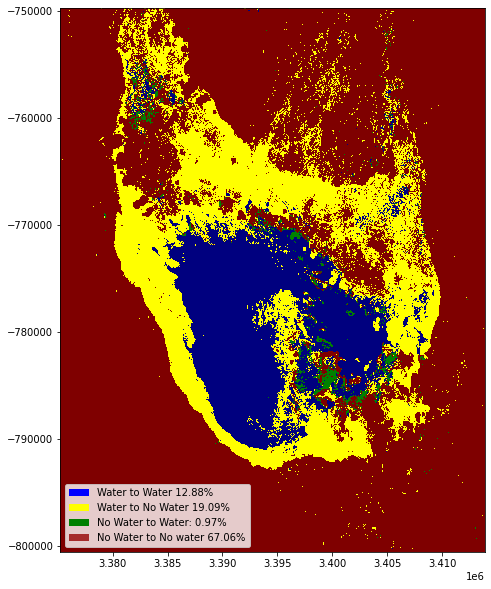

In [22]:
water_appeared_color = 'Green'
water_disappeared_color = 'Yellow'
stable_color = 'Blue'
land_color = 'Brown'

plot_aspect = image_aspect(ds_valid_water)

ds_valid_water.sel(time=time_xr[1]).plot.imshow(cmap='jet_r', add_colorbar=False, add_labels=False, size=10, aspect=plot_aspect)
water_appeared.plot.imshow(cmap=ListedColormap([water_appeared_color]), add_colorbar=False, add_labels=False)
water_disappeared.plot.imshow(cmap=ListedColormap([water_disappeared_color]), add_colorbar=False, add_labels=False)

plt.legend(
        [Patch(facecolor=stable_color), Patch(facecolor=water_disappeared_color), Patch(facecolor=water_appeared_color),   Patch(facecolor=land_color)], 
        [f'Water to Water {percentage_permanent_water}%', f'Water to No Water {percentage_water_loss}%' , f'No Water to Water: {percentage_water_gain}%',  
         f'No Water to No water {percentage_permanent_land}%'],
         loc = 'lower left'
    );

## Next steps


Return to the "Analysis parameters" section, modify some values (e.g. `latitude`, `longitude`, `start_year`, `end_year`) and re-run the analysis.
You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

Change the year aslo in "Compare Two Time Periods - a Baseline and an Analysis" section, (e.g. `base_year`, `analyse_year`) and re-run the analysis.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [23]:
print(datacube.__version__)

1.8.4.dev193+g3997b90f


**Last Tested:**

In [24]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-07-30'